# Sistema de Detecção de Spam

# Objetivo

Criar um classificador de detecção de span. Para isso, treinar com o dataset **train_data.csv** validar a coluna SMS do dataset **validation_data.csv** como “ok” ou “blocked” 

**RESPOSTA**: validation_data_com_LABEL.csv

# Objetivos Específicos

- Qualidade do código.
- Procedimentos (como os dados foram preparados/tratados, algoritmos utilizados, fundamentação
das escolhas tomadas).
- O nível de acerto da classificação também será avaliado, porém não será um critério fundamental
nesta análise.


# Resumo do Relatório

1. Coleta de Dados e Análise Inicial
2. Limpeza de Dados
3. Análise Exploratória de Dados
4. Pré-Modelagem
5. Modelagem
6. Avaliação de Métricas
7. Modelo em Produção
8. Considerações Finais

# Dependências

In [114]:
#Libs de Manipulação e Visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


#Libs de Processamento de Texto
import urlextract
import re  
from collections import Counter 

#Libs de NLP
import nltk                        
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords


#Libs de Preprocessamento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split

#Libs de ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

#Libs de Métricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# 1. Coleta de Dados e Análise Inicial

In [3]:
#Carregamento de dados de treinamento
df = pd.read_csv("Resources/train_data.csv", encoding='utf-8')
df.head()

,SMS,LABEL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked
3,Atualizacao ainda nao foi executado em sua con...,blocked
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked


In [4]:
#Carregamento de dados de validação
df_va = pd.read_csv("Resources/validation_data.csv", encoding='utf-8')
df_va.head()

,SMS
0,BB informa:Prezado cliente suas senhas de ACES...
1,BB informa:Prezado cliente suas senhas de ACES...
2,BB informa:Prezado cliente suas senhas de ACES...
3,Node Warning: SFRO01H000001.call.br Warning em...
4,BB informa:Prezado cliente suas senhas de ACES...


In [5]:
#Quantidade de comentários
df.shape[0]

6000

In [6]:
#Rótulos encontrados
df['LABEL'].unique()

array(['blocked', 'ok'], dtype=object)

In [7]:
#Verifica se existem dados faltante
df.isnull().values.any()

False

In [8]:
#Verifica o balanceamento das classes
df['LABEL'].value_counts()

ok         4500
blocked    1500
Name: LABEL, dtype: int64

# 2. Análise Exploratória de Dados

### Visualização da distribuição de comentários

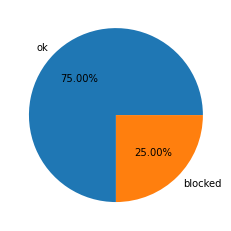

In [9]:
#Rótulos das classes
countLabel = np.array([df['LABEL'].value_counts()[0], df['LABEL'].value_counts()[1]])

#Nome dos rótulos
nameLabels = ["ok", "blocked"]

#Mostra o gráfico de pizza
plt.pie(countLabel, labels = nameLabels, autopct='%1.2f%%')
plt.show() 

- Nossos padrões estão desbalanceados, logo valores de métricas como a taxa de acerto não é eficaz para uma avaliação segura. 
- Para contornar o desbalanceamento, podemos utilizar modelos de reamostragem. 

**Métodos para lidar com datasets desbalanceados**
- Over-sampling: cria novas observações da classe minoritária a partir das informações contidas nos dados originais. ...
- Under-sampling: reduz o desbalanceamento do dataset focando na classe majoritária.

### Verificação de padrões

In [10]:
#Verifica padrões ok
df[df['LABEL'] == 'ok']

,SMS,LABEL
1500,recuperamos seu usuario e senha de acesso no i...,ok
1501,recuperamos seu usuario e senha de acesso no i...,ok
1502,"MARSH CORRETORA: Felipe, boleto parc. 01 do Se...",ok
1503,"MARSH CORRETORA: Felipe, boleto parc. 01 do Se...",ok
1504,"MARSH CORRETORA: Anna, boleto parc. 01 do Seg ...",ok
...,...,...
5995,Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...,ok
5996,Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...,ok
5997,Host : RB§Bicanga Ip: 170.244.231.14 nao esta ...,ok
5998,Host : RB_Bicanga Ip: 170.244.231.14 nao esta ...,ok


In [11]:
#Verifica padrões bloqueados
df[df['LABEL'] == 'blocked']

,SMS,LABEL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked
3,Atualizacao ainda nao foi executado em sua con...,blocked
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked
...,...,...
1495,BB INFORMA:VALIDE SUA SENHA E EVITE TRANSTORNO...,blocked
1496,BB INFORMA:VALIDE SUA SENHA E EVITE TRANSTORNO...,blocked
1497,BB INFORMA:VALIDE SUA SENHA E EVITE TRANSTORNO...,blocked
1498,BB INFORMA:VALIDE SUA SENHA E EVITE TRANSTORNO...,blocked


Coluna **LABEL** precisa ser transformada para um valor número, e coluna **SMS** precisa ser vetorizados

# 3. Modelagem e Aplicação de ML

Vamos verifica a eficiência do modelo considerando somente a coluna **LABEL**

### Modelagem

In [12]:
#Muda os rotulos para valores numéricos
df['LABEL_VALUE'] = df['LABEL'].map({'ok':0, 'blocked':1})

In [15]:
#Separação em teste e treino
X_train, X_test, y_train, y_test = train_test_split(df['SMS'], df['LABEL_VALUE'], test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4800,), (1200,), (4800,), (1200,))

Foi considerado somente o dataset **train_data.csv** para separação de dados de treinamento e teste. Foi modelado com 80% dos dados de treinamento e 20% com os dados de teste

In [16]:
#Instância o modelo CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('portuguese'))

#Aplica o modelo
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

#Mostra as dimensões
X_train_vect.shape, X_test_vect.shape

((4800, 6518), (1200, 6518))

### Aplicação de ML

In [75]:
#Algoritmos utilizados na análise
classifiers = [
    KNeighborsClassifier(),
    SVC(gamma='scale'),
    LogisticRegression(solver='lbfgs'),
    BaggingClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    MLPClassifier(),
    AdaBoostClassifier(),
    MultinomialNB()]

#Nomes dos algoritmos
names = ["Nearest Neighbors", "SVM", "LogisticRegression", "BaggingClassifier", "Decision Tree", "Random Forest", "MLP", "AdaBoost", "Naive Bayes"]

In [76]:
#Salva as informações
scores = []

#Aplicação dos modelos
for name, model in zip(names, classifiers):
    
    #Treina
    model.fit(X_train_vect, y_train)
    
    #Prediz
    predict = model.predict(X_test_vect)
    
    #Métrica de avalização
    score = f1_score(y_test, predict)
    
    #Salva a métrica de avaliação
    scores.append(score)

### Avaliação de métricas de treinamento

In [77]:
#Avaliação de métricas de treinamento
metrics_inicial_train = pd.DataFrame(data = scores, index = names, columns = ['f1_score']).sort_values(by='f1_score')
metrics_inicial_train

,f1_score
Nearest Neighbors,0.966226
Naive Bayes,0.986547
AdaBoost,0.989313
BaggingClassifier,0.990881
Decision Tree,0.990881
SVM,0.992390
LogisticRegression,0.992390
Random Forest,0.995448
MLP,0.998487


Os modelo **Decision Tree, Random Forest e MLP** foram os mais eficientes na etapa de treinamento e teste do conjunto de treinamento. Irei escolher o método **MLP** para prever o dataset de avaliação

### Avaliação de métricas do dataset de avaliação

In [78]:
#Treinar movamente o modelo escolhido
model = MLPClassifier()

#Treina
model.fit(X_train_vect, y_train)
    
#Prediz
predict = model.predict(X_test_vect_aval)

In [104]:
#Transforma em tabela o valor predito
SMS_av = pd.DataFrame(predict, columns = ['LABEL'])
SMS_av

,LABEL
0,1
1,1
2,1
3,0
4,1
...,...
1995,0
1996,0
1997,0
1998,0


In [105]:
SMS_av['LABEL'] = SMS_av['LABEL'].map({0:'ok', 1:'blocked'})
SMS_av

,LABEL
0,blocked
1,blocked
2,blocked
3,ok
4,blocked
...,...
1995,ok
1996,ok
1997,ok
1998,ok


In [106]:
#Concatena as duas colunas
df_val = pd.concat([df_va['SMS'], SMS_av], axis=1)

#Muda o valor número para 
df_val

,SMS,LABEL
0,BB informa:Prezado cliente suas senhas de ACES...,blocked
1,BB informa:Prezado cliente suas senhas de ACES...,blocked
2,BB informa:Prezado cliente suas senhas de ACES...,blocked
3,Node Warning: SFRO01H000001.call.br Warning em...,ok
4,BB informa:Prezado cliente suas senhas de ACES...,blocked
...,...,...
1995,Faça login no aplicativo OlympTrad?: 179.240.1...,ok
1996,Faça login no aplicativo OlympTrad?: 179.240.1...,ok
1997,bitnuvem.com: Identificamos acesso do IP 179.2...,ok
1998,"enterinapplication: 179.240.169.116, BR, For...",ok


In [108]:
#Distribuição das classes
df_val['LABEL'].value_counts()

ok         1508
blocked     492
Name: LABEL, dtype: int64

In [107]:
#Salva os valores em um arquivo CSV
df_val.to_csv('Resources/validation_data_com_LABEL.csv')

Com isso, O modelo já consegue detectar spams em mensagens de e-mail, com uma boa efiência

Porém, Podemos analisar se o modelo pode performar melhor com a extração de caracteristicas

# 4. Busca de otimização

### Cria caracteristicas particulares dos padrões

In [88]:
#Número de caracteres de cada padrão
df['LENGTH'] = df['SMS'].apply(len)
df.head()

,SMS,LABEL,LABEL_VALUE,LENGTH
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked,1,142
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked,1,52
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked,1,47
3,Atualizacao ainda nao foi executado em sua con...,blocked,1,109
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked,1,47


In [89]:
#Média de tamanho de caracteres de cada classe
Y = [df[df['LABEL'] == 'ok']['LENGTH'].mean(), df[df['LABEL'] == 'blocked']['LENGTH'].mean()]

#Apresentação
print('Média de tamanho de caracteres de cada classe')
print('Classe ok :', round(Y[0]))
print('Classe blocked :', round(Y[1]))

Média de tamanho de caracteres de cada classe
Classe ok : 105
Classe blocked : 97


In [90]:
#Captura as palavras em caixa alta
def up_low(s):
    upper_case_count = 0
    lower_case_count = 0

    split_s = s.split()

    for word in split_s:

        if word.islower() == False:
            upper_case_count +=1
            lower_case_count += len(word) - 1
        elif word.islower() == True:
            letter_count = len(word)
            lower_case_count += letter_count
            
    return upper_case_count

In [91]:
#Cria variável de número de palavras em caixa alta
df['UPPER_WORD'] = df['SMS'].apply(up_low)
df.head()

,SMS,LABEL,LABEL_VALUE,LENGTH,UPPER_WORD
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked,1,142,24
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked,1,52,2
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked,1,47,1
3,Atualizacao ainda nao foi executado em sua con...,blocked,1,109,3
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked,1,47,1


In [92]:
#Média da quantidade de palavras em caixa alta de cada classe
Y = [df[df['LABEL'] == 'ok']['UPPER_WORD'].mean(), df[df['LABEL'] == 'blocked']['UPPER_WORD'].mean()]

#Apresentação
print('Média da quantidade de palavras em caixa alta de cada classe')
print('Classe ok :', round(Y[0]))
print('Classe blocked :', round(Y[1]))

Média da quantidade de palavras em caixa alta de cada classe
Classe ok : 7
Classe blocked : 8


In [93]:
#Conta número de hashtags
def count_hash(sms):
    words = sms.split()
    hashs = [word for word in words if word.startswith('@')]
    return(len(hashs))

In [94]:
#Cria variável de número de hashtags
df['HASH_COUNT'] = df['SMS'].apply(count_hash)
df.head()

,SMS,LABEL,LABEL_VALUE,LENGTH,UPPER_WORD,HASH_COUNT
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked,1,142,24,0
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked,1,52,2,0
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked,1,47,1,0
3,Atualizacao ainda nao foi executado em sua con...,blocked,1,109,3,0
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked,1,47,1,0


In [95]:
#Média da quantidade de palavras em hashtags de cada classe
Y = [df[df['LABEL'] == 'ok']['HASH_COUNT'].mean(), df[df['LABEL'] == 'blocked']['HASH_COUNT'].mean()]

#Apresentação
print('Média da quantidade de hashtags de cada classe')
print('Classe ok :', Y[0])
print('Classe blocked :', Y[1])

Média da quantidade de hashtags de cada classe
Classe ok : 0.0017777777777777779
Classe blocked : 0.0


In [96]:
#Cria variável de números
df['WORD_NUMERIC'] = 0

#Processamento
for i in np.arange(0,len(df['SMS'])):
    df.loc[i,'WORD_NUMERIC'] = 1 if len(re.findall(r'\d+(?:\.\d*(?:[eE]\d+))?', df.loc[i,'SMS'])) > 0 else 0
    
#Apresentação
df.head()

,SMS,LABEL,LABEL_VALUE,LENGTH,UPPER_WORD,HASH_COUNT,WORD_NUMERIC
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked,1,142,24,0,1
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked,1,52,2,0,1
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked,1,47,1,0,1
3,Atualizacao ainda nao foi executado em sua con...,blocked,1,109,3,0,0
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked,1,47,1,0,1


In [97]:
#Média da quantidade de números de cada classe
Y = [df[df['LABEL'] == 'ok']['WORD_NUMERIC'].mean(), df[df['LABEL'] == 'blocked']['WORD_NUMERIC'].mean()]

#Apresentação
print('Média da quantidade de números de cada classe')
print('Classe ok :', Y[0])
print('Classe blocked :', Y[1])

Média da quantidade de números de cada classe
Classe ok : 0.9913333333333333
Classe blocked : 0.8773333333333333


In [98]:
#Instância o processamento de texto
url_extractor = urlextract.URLExtract()

#Cria variável de links
df['URL'] = 0

#Processamento
for i in np.arange(0, len(df['SMS'])):
    df.loc[i,'URL'] = 1 if len(url_extractor.find_urls(df.loc[i,'SMS'])) > 0 else 0
    
#Apresentação
df.head()

,SMS,LABEL,LABEL_VALUE,LENGTH,UPPER_WORD,HASH_COUNT,WORD_NUMERIC,URL
0,BOLETO REFERENTE AS PARCELAS EM ATRASO DO CONS...,blocked,1,142,24,0,1,1
1,050003DA0202|lcloud-apple-lnc.com/?iphone=VtBq...,blocked,1,52,2,0,1,1
2,060804CB5F0303|ps: //bancodobrasil.seguranca.gq,blocked,1,47,1,0,1,1
3,Atualizacao ainda nao foi executado em sua con...,blocked,1,109,3,0,0,1
4,0608042BE40303|ps://bancodobrasil.seguranca.cf/,blocked,1,47,1,0,1,1


In [99]:
#Média da quantidade de links de cada classe
Y = [df[df['LABEL'] == 'ok']['URL'].mean(), df[df['LABEL'] == 'blocked']['URL'].mean()]

#Apresentação
print('Média da quantidade de links de cada classe')
print('Classe ok :', Y[0])
print('Classe blocked :', Y[1])

Média da quantidade de links de cada classe
Classe ok : 0.18511111111111112
Classe blocked : 0.988


Foram criados alguns campos no dataset para verificar particularidades do texto, como número de URL, número de dígitos, número de hashtag, número de palavras em caixa alta, número de caracteres.

1. **número de caracteres:** as classes bloqueadas possuem um pouco mais de caracteres
2. **número de dígitos:** as duas classes apresentam quase a mesma quantidade
3. **número de hashtag:** a classes bloqueada apresento **zero** @
4. **número de em caixa alta** as duas classes apresentam quase a mesma quantidade
5. **número de URL:** a classe bloqueada apresenta bem mais frequência de links

In [167]:
#Captura os padrões de cada classe
msg_blocked = df[df['LABEL'] == 'blocked']['SMS']
msg_ok = df[df['LABEL'] == 'ok']['SMS']

#Transformar em texto
msg_blocked = msg_blocked.to_json()
msg_ok = msg_ok.to_json()

#Retira caracteristicas indesejadas
msg_blocked = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '', msg_blocked)
msg_ok = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '', msg_ok)

In [170]:
#Função forma mensagem com palavras unicas
def formMessagem(msg):

  txt = ''
  
  for i in range(len(msg)):
    txt = txt + ' ' + msg[i] 

  return txt

#Função vai contar a ocorrencia de cada palavra
def moda(msg, ocorrencia):

    msg = msg.split()
    ocorrencia = ocorrencia.split()

    lista = []

    for i in ocorrencia:
        for j in msg:
            if i == j:
                lista.append(j)
    return Counter(lista)

In [171]:
#Palavras unicas
msg_blocked_x = np.unique(msg_blocked.split())

msg_ok_x = np.unique(msg_ok.split())

In [173]:
#Criar tabela com o número de palavras únicas e a sua ocorrência
msg_blocked = pd.melt(pd.DataFrame(moda(msg_blocked, formMessagem(msg_blocked_x)), index=[1]))
msg_blocked.columns=['Palavra', 'Ocorrência']

#Procura as 20 palavras com maior ocorrência
msg_blocked.sort_values(['Ocorrência'], ascending=False).head(20)

,Palavra,Ocorrência
246,E,867
417,SENHA,863
423,SUA,863
248,EVITE,655
301,INFORMA:VALIDE,641
458,TRANSTORNO,641
147,ACESSE:,641
300,INFORMA:,226
249,EXPIROU,222
328,J,222


In [172]:
#Criar tabela com o número de palavras únicas e a sua ocorrência
msg_ok = pd.melt(pd.DataFrame(moda(msg_ok, formMessagem(msg_ok_x)), index=[1]))
msg_ok.columns=['Palavra', 'Ocorrência']

#Procura as 20 palavras com maior ocorrência
msg_ok.sort_values(['Ocorrência'], ascending=False).head(20)

,Palavra,Ocorrência
12005,no,1481
11917,login,1422
7623,BR,1412
9743,OlympTrad:,1411
11356,aplicativo,1406
12324,seu,1287
11576,de,1098
9334,Ligue,1041
11577,debito,926
1407,08006002934,758


In [127]:
words_ok = df[df['LABEL']=='ok']['SMS'].tolist()
words_block = df[df['LABEL']=='blocked']['SMS'].tolist()

# diminuindo uma dimensão das listas
list_words_ok = []
for sublist in words_ok:
    for item in sublist:
        list_words_ok.append(item)
list_words_block = []
for sublist in words_block:
    for item in sublist:
        list_words_block.append(item)
        
# Selecionando as 30 mais frequentes de cada categoria
list_words_ok  = Counter(list_words_ok)
list_words_block = Counter(list_words_block)
top30_ok  = pd.DataFrame(list_words_ok.most_common(30),  columns=['word', 'count'])
top30_block = pd.DataFrame(list_words_block.most_common(30), columns=['word', 'count'])

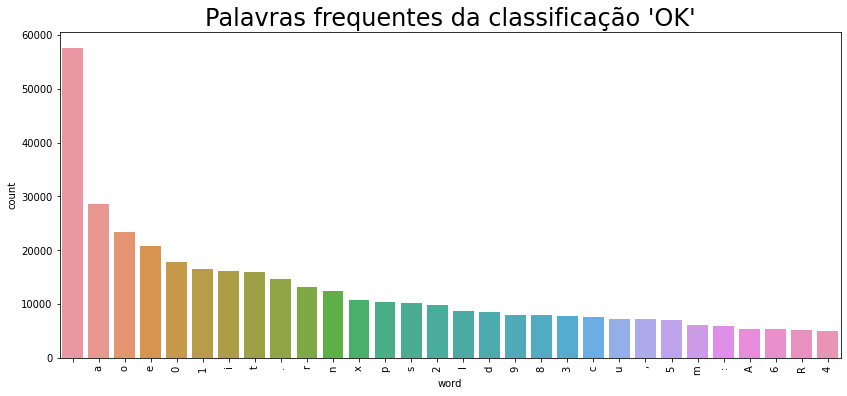

In [128]:
# Plotando os resultados
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x='word', y='count', 
            data=top30_ok, ax=ax)
plt.title("Palavras frequentes da classificação 'OK'", fontsize = 24)
plt.xticks(rotation='vertical');